In [8]:
import os, time
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

In [9]:
root = os.path.dirname(os.path.dirname(os.getcwd()))

train_dir = os.path.join(root, 'data', 'current', 'train')

IMAGE_DIM = 200
NB_CLASS = 3
NB_EPOCH = 20
L_RATE = 0.001
BATCH = 64

In [10]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,             # Zoom
    rotation_range=20,          # Rotation des images
    width_shift_range=0.001,      # Translation horizontale
    height_shift_range=0.001,     # Translation verticale
    shear_range=0.01,            # Transformation affine
    horizontal_flip=True,       # Symétrie horizontale
    fill_mode='nearest',        # Remplir les zones vides après transformation
    validation_split=0.2        # Division en validation
)

train_data = datagen_train.flow_from_directory(
    train_dir,
    seed = 42,
    color_mode = 'rgb',
    target_size=(IMAGE_DIM, IMAGE_DIM), 
    batch_size=BATCH,
    class_mode='categorical',      
    subset='training'
)

val_data = datagen_train.flow_from_directory(
    train_dir,
    seed = 42,
    color_mode = 'rgb',
    target_size=(IMAGE_DIM, IMAGE_DIM),
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation'
)

Found 1080 images belonging to 3 classes.
Found 269 images belonging to 3 classes.


In [11]:

def model_builder (model, name = str(time.time()), epoch = NB_EPOCH, lr = L_RATE):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    # -- compile --
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print(model.summary())
    class_weights = dict(enumerate(compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_data.classes),
        y=train_data.classes
    )))
    # -- train --
    # Use checkpoints
    checkpoint_path =  os.path.join(root, 'model', 'checkpoints', 'cp.weights.h5')
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=3, verbose=1
    )
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epoch,
        callbacks=[cp_callback, lr_callback, early_stopping],
        # steps_per_epoch=train_steps,
        # validation_steps=val_steps,
        class_weight=class_weights
    )
    # -- save --
    save_path =  os.path.join(root, 'model', 'main', 'model_' + name + '.h5')
    model.save(save_path)
    # -- Evaluate --
    test_loss, test_acc = model.evaluate(val_data)
    print(f"Test Accuracy: {test_acc*100:.2f}%")

    # Prédictions sur le set de test
    predictions = model.predict(val_data)
    predicted_classes = predictions.argmax(axis=1)
    print("Predictions done.")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

None
Epoch 1/20


c:\Users\tgoor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4583 - loss: 3.2290
Epoch 1: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 175s 10s/step - accuracy: 0.4627 - loss: 3.1767 - val_accuracy: 0.8587 - val_loss: 0.4899 - learning_rate: 0.0010
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8050 - loss: 0.5224
Epoch 2: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 172s 10s/step - accuracy: 0.8057 - loss: 0.5202 - val_accuracy: 0.9108 - val_loss: 0.2843 - learning_rate: 0.0010
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8953 - loss: 0.2834
Epoch 3: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 172s 10s/step - accuracy: 0.8954 - loss: 0.2831 - val_accuracy: 0.9442 - val_loss: 0.2204 - learning_rate: 0.0010
Epoch 4/20
17/1

5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.9838 - loss: 0.0361
Test Accuracy: 98.51%
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step
Predictions done.


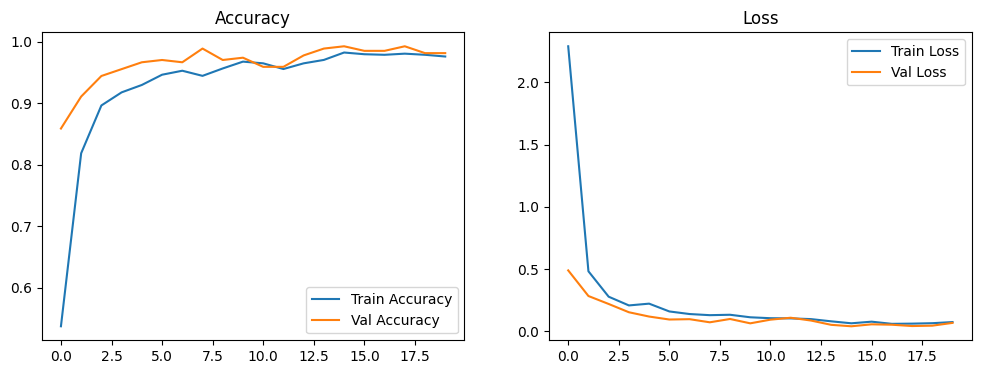

In [12]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_DIM,IMAGE_DIM,3))
# Freeze les couches de base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# VGG16
model_builder(model,'VGG19_512')